In [ ]:
!pip install pyspellchecker -q

     |████████████████████████████████| 2.7 MB 5.2 MB/s 


In [ ]:
import pandas as pd
from google.colab import drive
import re
from spellchecker import SpellChecker
import numpy as np


## Load data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir = "directory here"

In [ ]:
df = pd.read_csv(dir+'data_cleaned.csv')

In [ ]:
df.head()

,Idiom,Sense,Idiomatic_Sent,Literal_Sent,Idiomatic_Label,Literal_Label
0,the benefit of the doubt,regards a person as innocent unless confirmed ...,Let 's give her the benefit of the doubt and a...,Let 's regard her as innocent and assume that ...,O O B O I I I I I O O O O O O O,O O B O I I O O O O O O O
1,the benefit of the doubt,regards a person as innocent unless confirmed ...,I do n't believe that he did n't take the mone...,I do n't believe that he did n't take the mone...,O O O O O O O O O O O O O O O B O O I I O I O ...,O O O O O O O O O O O O O O O O O O O O O O O
2,the benefit of the doubt,regards a person as innocent unless confirmed ...,She said that she will be on time today and I ...,She said that she will be on time today and I ...,O O O O O O O O O O O O O O O O O O O O O O O ...,O O O O O O O O O O O O O O O O O O O O O B O ...
3,the benefit of the doubt,regards a person as innocent unless confirmed ...,Give him the benefit of the doubt and he 'll g...,Regard him as innocent and he 'll go free .,B O I I I I I O O O O O O,B O I I O O O O O O
4,the benefit of the doubt,regards a person as innocent unless confirmed ...,The court gave the wrongly accused man the ben...,The court regarded the wrongly accused man as ...,O O B O O O O O I I O I O,O O B O O O O I I I I I O


## Count number of idioms

Not sure whether to count an idiom with different meanings as different idioms or not.

Idiom                          Sense                                                                                             
rise and shine                 to wake up and get out of bed                                                                         14
armed to the teeth             carrying many weapons                                                                                 13
chill to the bone              to get frightened or scare somebody                                                                   13
as easy as pie                 an easy thing                                                                                         12
bang on                        to be exact, to be most accurate                                                                      12
                                                                                                                                     ..
lean towards                   incline towards        

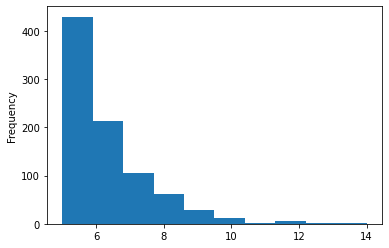

In [ ]:
# Considering each idiom+sense as a different idiom
id_sen_counts = df.value_counts(["Idiom", "Sense"])
print(id_sen_counts)

id_sen_counts.plot.hist()


Idiom                        
catch up                         15
run out                          15
black hole                       15
screw up                         15
rise and shine                   14
                                 ..
laughter is the best medicine     5
laughing stock                    5
know the ropes                    5
knock one’s socks off             5
match made in heaven              5
Length: 823, dtype: int64


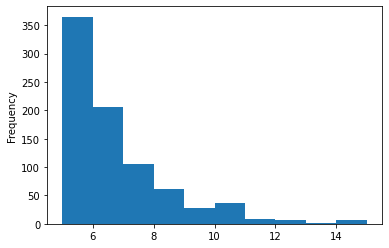

In [ ]:
# Considering each idiom, including each of its senses, as one idiom
idiom_counts = df.value_counts(["Idiom"])
print(idiom_counts)

idiom_counts.plot.hist()

Idiom               
catch up                3
black hole              3
run out                 3
screw up                3
couch potato            2
                       ..
fingers crossed         1
finishing touch         1
first light             1
first things first      1
zoom away | zoom off    1
Length: 823, dtype: int64


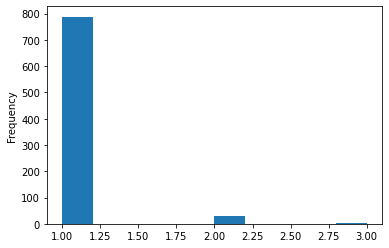

In [ ]:
# Number of senses per idiom
numsense_counts = id_sen_counts.to_frame().value_counts(["Idiom"])
print(numsense_counts)
numsense_counts.plot.hist()

In [ ]:
# Find min and max length (! Not sure if the prefix counts as well !)
lengths_id = df["Idiomatic_Sent"].str.split(" ")
print("Max number of words Idiomatic = ", lengths_id.str.len().max())
lengths_lit = df["Literal_Sent"].str.split(" ")
print("Max number of words Literal = ", lengths_lit.str.len().max())


Max number of words Idiomatic =  73
Max number of words Literal =  61


## Try to find a way to match the given idiom to the form in which it appears in the sentence.

In this way, we can tell T5 that this is the part that it needs to translate and not the rest.

#### Spacy Phrasematcher

In [ ]:
import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('en')
matcher = PhraseMatcher(nlp.vocab, attr="LEMMA")

string = "I was so caught up in the beauty of the art work that I failed to notice her ."

matcher.add("1", None, nlp("catch up"))
matches = matcher(nlp(string)) 
match = string.split(" ")[matches[0][1]:matches[0][2]]
print(match)

['caught', 'up']


In [ ]:
# This one doesn't work because for some reason the definition contains "the"",
# but not the sentence

import spacy
from spacy.matcher import PhraseMatcher

nlp = spacy.load('en')
matcher = PhraseMatcher(nlp.vocab, attr="LEMMA")

string = "She has been burning the candle at both ends by doing a full-time job and preparing for her International English Language Test exams ."

matcher.add("1", None, nlp("burn the candle at both the ends"))
matches = matcher(nlp(string)) 
#match = string.split(" ")[matches[0][1]:matches[0][2]]
print(matches)

[]


#### Using IOB tags

In [ ]:
# Alternatively use the given labels
# The first idiom
labels = df["Idiomatic_Label"].iloc[5147].split(" ")
string = df["Idiomatic_Sent"].iloc[5147].split(" ")
print(string)
print(df["Idiom"].iloc[5147])
id = []
for i in range(0,len(string)):
  if labels[i] == "B":
    id.append(string[i])
  if labels[i] == "I":
      id.append(string[i])

print(' '.join(id))

print()
# The second idiom
labels = df["Idiomatic_Label"].iloc[4413].split(" ")
string = df["Idiomatic_Sent"].iloc[4413].split(" ")
print(string)
print(df["Idiom"].iloc[4413])
id = []
for i in range(0,len(string)):
  if labels[i] == "B":
    id.append(string[i])
  if labels[i] == "I":
      id.append(string[i])

print(' '.join(id))
  
  

NameError: ignored

In [ ]:
# Do this to the whole dataset. Turns out the dataset is quite inconsistent with for instance including "the"'s
actual_id = []
for i in range(len(df)):
  labels = df["Idiomatic_Label"].iloc[i].split(" ")
  string = df["Idiomatic_Sent"].iloc[i].split(" ")
  id = []
  for i in range(0,len(string)):
    if labels[i] == "B":
      id.append(string[i])
    if labels[i] == "I":
        id.append(string[i])
  actual_id.append(' '.join(id))

df["Actual_Id"] = actual_id
print(df)

## Clean and preprocess data

#### Clean data a bit
- Remove random characters that shouldn't be there
- Normalize characters such as quotation marks (multiple types appear)
- Try fixing spelling/grammar mistakes


In [ ]:
# Find what characters are used
chars = set(df["Idiomatic_Sent"].apply(list).sum())
chars.union(set(df["Literal_Sent"].apply(list).sum()))

print(chars)

# Need to remove atleast ê, ¾, Õ, ™, â, Â, +, € since they are actually mistakes that shouldn't be there
# Can probably keep punctuation. Also % and $ (only appear in a few sentences, used correctly)
# Maybe replace "&" by "and"

{'$', 'K', '`', 'w', ')', 'Â', '—', 'S', '8', '0', 'P', 'z', 'i', 's', '.', 'b', 'y', 'l', '!', 'Õ', 'm', '(', 'H', '2', 'N', ';', 'c', '¾', 'x', '4', ' ', '”', 'v', 'W', 'B', '€', 'E', 'V', 'Y', 'C', 't', 'â', 'R', 'g', '6', 'j', '&', 'F', 'G', 'f', 'u', ',', '-', '™', 'r', '7', 'h', 'T', '9', 'a', '3', 'J', '%', "'", 'M', '?', 'q', 'o', 'L', 'd', 'k', '’', 'D', 'I', 'e', '+', '1', 'U', 'n', 'A', '5', 'Q', 'ê', 'O', ':', 'Z', 'p'}


In [ ]:
# Clean data
df_clean = df.copy(deep=True)
for i in range(len(df_clean.columns)):
  # Remove characters
  df_clean.iloc[:,i] = df_clean.iloc[:,i].apply(lambda x: re.sub("[ê¾Õ™âÂ+€�]","", x))

  # Normalize quotations
  df_clean.iloc[:,i] = df_clean.iloc[:,i].apply(lambda x: re.sub("’", "'", x))
  df_clean.iloc[:,i] = df_clean.iloc[:,i].apply(lambda x: re.sub("''|``|”","\"", x))
  # Normalize —
  df_clean.iloc[:,i] = df_clean.iloc[:,i].apply(lambda x: re.sub("—|--","-", x))


# Example
print(df["Idiomatic_Sent"].iloc[3940])
print(df_clean["Idiomatic_Sent"].iloc[3940])



TheÂ bossÂ wasÂ madÂ becauseÂ TomÂ calledÂ itÂ aÂ dayÂ atÂ noonÂ andÂ wentÂ home .
The boss was mad because Tom called it a day at noon and went home .


In [ ]:
# (OPTIONAL) Merge together contractions again
def merge_contractions(text):
    # Add spaces around every ' for consistency
    newtext = re.sub("'", " ' ", text) # Add spaces around every ' 
    newtext = re.sub(" +", " ", newtext) # Remove extra spaces
    # To deal with ''
    newtext = re.sub(" ' ' ", " '' ", newtext)
    newtext = re.sub(" $","", newtext)
    newtext = re.sub("^ ","", newtext)

    # Merge contractions
    newtext = re.sub(" ' s ", "'s ", newtext)
    newtext = re.sub("I ' m ", "I'm ", newtext)
    newtext = re.sub(" ' ll ", "'ll ", newtext)
    newtext = re.sub(" ' ve ", "'ve ", newtext)
    newtext = re.sub(" ' d ", "'d ", newtext)
    newtext = re.sub(" ' re ", "'re ", newtext)
    newtext = re.sub(" ' t ", "'t ", newtext)
    newtext = re.sub(" n't ", "n't ", newtext) # To deal with "do n't"

    return newtext


In [ ]:
# Merge contractions
for i in range(len(df_clean.columns)):
  df_clean.iloc[:,i] = df_clean.iloc[:,i].apply(lambda x: merge_contractions(x))

# Example
#print(df["Idiomatic_Sent"].iloc[1242])
#print(df_clean["Idiomatic_Sent"].iloc[1242])

print(df["Literal_Sent"].iloc[3410])
print(df_clean["Literal_Sent"].iloc[3410])


'We 'll See , ' Trump Says on North Korea and And Iran and And Nafta and And many other things .
' We'll See , ' Trump Says on North Korea and And Iran and And Nafta and And many other things .


In [ ]:
# Try to find grammar/spelling errors
spell = SpellChecker()

for col in ["Idiomatic_Sent", "Literal_Sent"]:
  for i in range(len(df_clean)):
    a = df_clean[col].iloc[i]
    misspelled = spell.unknown(a.split(" "))
    for word in misspelled:
      if str(word) != spell.correction(word):
        print(str(col)+", "+str(i)+": "+"original: "+str(word)+"      suggested text: "+str(spell.correction(word)))


Idiomatic_Sent, 25: original: in-laws      suggested text: inlaws
Idiomatic_Sent, 77: original: full-time      suggested text: fulltime
Idiomatic_Sent, 88: original: ogy      suggested text: orgy
Idiomatic_Sent, 138: original: mother-in-law      suggested text: motherinlaw
Idiomatic_Sent, 203: original: bluethe      suggested text: blithe
Idiomatic_Sent, 276: original: z      suggested text: i
Idiomatic_Sent, 277: original: z      suggested text: i
Idiomatic_Sent, 278: original: z      suggested text: i
Idiomatic_Sent, 279: original: z      suggested text: i
Idiomatic_Sent, 280: original: z      suggested text: i
Idiomatic_Sent, 281: original: z      suggested text: i
Idiomatic_Sent, 282: original: z      suggested text: i
Idiomatic_Sent, 283: original: z      suggested text: i
Idiomatic_Sent, 284: original: z      suggested text: i
Idiomatic_Sent, 285: original: z      suggested text: i
Idiomatic_Sent, 295: original: teen-aged      suggested text: teenaged
Idiomatic_Sent, 301: origina

In [ ]:
print(df.iloc[5149])
print(df_clean.iloc[5149])

Idiom                                                       catch up
Sense                          to be utterly fascinated by something
Idiomatic_Sent     It 's a bad idea to get caught up in a dangero...
Literal_Sent       It 's a bad idea to beome immersed in a danger...
Idiomatic_Label                          O O O O O O B I I O O O O O
Literal_Label                              O O O O O O B I O O O O O
Actual_Id                                              get caught up
Name: 5149, dtype: object
Idiom                                                       catch up
Sense                          to be utterly fascinated by something
Idiomatic_Sent     It's a bad idea to get caught up in a dangerou...
Literal_Sent       It's a bad idea to beome immersed in a dangero...
Idiomatic_Label                          O O O O O O B I I O O O O O
Literal_Label                              O O O O O O B I O O O O O
Actual_Id                                              get caught up
Name: 51

### Put data in right format for T5
For two cases:
- With prefix giving sentence as well as idiom
- Without prefix and appending idiom

#### Split data into training, test and validation
For it to work, we need each idiom in test/validation to be in training,otherwise it won't know it. We have 862 idiom senses and 5172 sentences.

Two potential ways to split the data:

- One sentence per idiom sense for test, one for validation and the rest for training (gives train/test/validation = 17%/17%/67%)
- Take one sentence per idiom sense and assign to either test or validation, then assign the rest to training (gives train/test/validation = 8%/8%/83%)

In [ ]:
# 1 in test, 1 in validation, 1 in training per idiom sense
def split_data_1(data, addStars=False):
  idiom = ""
  sense = ""
  count = 0 # To see which set the row should be added to
  split = {"train": [], "test": [], "val": []}

  for i in range(len(data)):
    if data["Idiom"].iloc[i] != idiom and data["Sense"].iloc[i] != sense:
      # First time we see the idiom, add to test
      split["test"].append(i)
      idiom = data["Idiom"].iloc[i]
      sense = data["Sense"].iloc[i]
      count = 1
    elif count == 1:
      # Second time we see the idiom, add to validation
      split["val"].append(i)
      count = 0
    else:
      # Already one sentence in test and validation, add the rest to train
      split["train"].append(i)
  
  # Create dataframes
  train = data.iloc[split["train"]].reset_index(drop=True)
  test = data.iloc[split["test"]].reset_index(drop=True)
  val = data.iloc[split["val"]].reset_index(drop=True)
  if addStars:
    train = addStarsToIdioms(train)
    test = addStarsToIdioms(test)
    val = addStarsToIdioms(val)

  return train, test, val


In [ ]:
def split_data_2(data):
  idiom = ""
  sense = ""
  count = 0 # To see which set the row should be added to
  split = {"train": [], "test_val":[]}

  for i in range(len(data)):
    if data["Idiom"].iloc[i] != idiom and data["Sense"].iloc[i] != sense:
      # First time we see the idiom, add to test-validation combined set
      split["test_val"].append(i)
      idiom = data["Idiom"].iloc[i]
      sense = data["Sense"].iloc[i]
      count = 1
    else:
      # Already one sentence in test-validation combined, add the rest to train
      split["train"].append(i)
    
    
  # Create dataframes
  train = data.iloc[split["train"]].reset_index(drop=True)
  test_val = data.iloc[split["test_val"]].reset_index(drop=True)

  test, val = np.array_split(test_val, 2)

  return train, test, val

In [ ]:
def addStarsToIdioms(df):
  for i, sent in enumerate(df['Idiomatic_Sent']):
    idiom = df['Idiom'].loc[i]
    df['Idiomatic_Sent'].loc[i] = df['Idiomatic_Sent'].loc[i].replace(idiom, f'*{idiom}*')
  return df



#### Put data into dataframes for T5 with/without prefix

Testing it out

In [ ]:
# With appending the idiom
data = pd.DataFrame()
data['input'] = df_clean.agg('id_par sentence: {0[Idiomatic_Sent]} idiom: {0[Idiom]}'.format, axis=1)
data['target'] = df_clean['Literal_Sent']
print(data["input"].iloc[0])
print(data["target"].iloc[0])

id_par sentence: Let's give her the benefit of the doubt and assume that she is right . idiom: the benefit of the doubt
Let's regard her as innocent and assume that she is right .


In [ ]:
# Without appending the idiom (and without prefix)
data2 = pd.DataFrame()
data2['input'] = df_clean['Idiomatic_Sent']
data2['target'] = df_clean['Literal_Sent']
print(data2["input"].iloc[0])
print(data2["target"].iloc[0])

Let's give her the benefit of the doubt and assume that she is right .
Let's regard her as innocent and assume that she is right .


#### Prepare training, test and validation data

In [ ]:
# Format a dataframe into the input for the T5 model with prefix and idiom
def format_t5_1(df):
  data = pd.DataFrame()
  data['input'] = df.agg('id_par sentence: {0[Idiomatic_Sent]} idiom: {0[Idiom]}'.format, axis=1)
  data['target'] = df['Literal_Sent']
  data['IOB_input'] = df['Idiomatic_Label']
  data['IOB_target'] = df['Literal_Label']
  return data

In [ ]:
# Format a dataframe into the input for the T5 model without prefix
def format_t5_2(df):
  data = pd.DataFrame()
  data['input'] = df['Idiomatic_Sent']
  data['target'] = df['Literal_Sent']
  return data

In [ ]:
# Format a dataframe into the input for the T5 model with just prefix
def format_t5_3(df):
  data = pd.DataFrame()
  data['input'] = df.agg('paraphrase: {0[Idiomatic_Sent]}'.format, axis=1)
  data['target'] = df['Literal_Sent']
  return data

In [ ]:
# Format the split data and save to csv - Id_par+idiom

train, test, val = split_data_1(df_clean, addStars=True)
# train, test, val = split_data_2(df_clean)

data_train = format_t5_1(train)
data_test = format_t5_1(test)
data_val = format_t5_1(val)

# print(data_train.head)
# print(data_test.head)
# print(data_val.head)

dir = dir = "/content/drive/MyDrive/Pipeline/Data/Idpar_Idiom_IOB_Stars/"

# Save to csv
data_train.to_csv(dir+"data_train.csv", index=False, sep="=")
data_test.to_csv(dir+"data_test.csv", index=False, sep="=")
data_val.to_csv(dir+"data_val.csv", index=False, sep="=")


In [ ]:
# Format the split data and save to csv - No idiom or label prepended /appended

train, test, val = split_data_1(df_clean)
# train, test, val = split_data_2(df_clean)

data_train = format_t5_2(train)
data_test = format_t5_2(test)
data_val = format_t5_2(val)

# print(data_train.head)
# print(data_test.head)
# print(data_val.head)

# Save to csv
data_train.to_csv(dir+"data_noid_nolabel_train.csv", index=False, sep="=")
data_test.to_csv(dir+"data_noid_nolabel_test.csv", index=False, sep="=")
data_val.to_csv(dir+"data_noid_nolabel_val.csv", index=False, sep="=")

In [ ]:
# Format the split data and save to csv - Paraphrase prefix

# train, test, val = split_data_1(df_clean)
train, test, val = split_data_2(df_clean)

data_train = format_t5_3(train)
data_test = format_t5_3(test)
data_val = format_t5_3(val)

# print(data_train.head)
# print(data_test.head)
# print(data_val.head)

# Save to csv
data_train.to_csv(dir+"data_par_train.csv", index=False, sep="=")
data_test.to_csv(dir+"data_par_test.csv", index=False, sep="=")
data_val.to_csv(dir+"data_par_val.csv", index=False, sep="=")
